In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import pandas as pd
import tqdm
import seaborn as sns

In [3]:
from pymonntorch import *
from conex import *

In [532]:
WINDOW_WIDTH = 50
WINDOW_HEIGHT = 50

window_x = [-WINDOW_WIDTH/2, +WINDOW_WIDTH/2]
window_y = [-WINDOW_HEIGHT/2, +WINDOW_HEIGHT/2]

def conv(angel) : 
    x = np.cos(np.radians(angel))
    y = np.sin(np.radians(angel))

    return x, y

def random_walk(length, R = 20,  initialize = True) : 

    if(initialize) : 
        pos_x = [0]
        pos_y = [0]

    theta = np.random.randint(0, 360)
    cnt = 0
    length_cnt = 0

    for _ in range(length) : 

        dist = np.sqrt(pos_x[-1]**2 + pos_y[-1]**2)
        # print(dist)
        if(dist > R) : 
            ang = np.angle(complex(pos_x[-1], pos_y[-1]), deg = True)
            theta = ang + np.random.randint(90, 180) % 360

        # theta = np.random.randint(0, 360)

        pos_x.append(pos_x[-1] + (conv(theta)[0] + 6/5 * np.random.uniform(-0.5,0.5)) * 1/10)
        pos_y.append(pos_y[-1] + (conv(theta)[1] + 6/5 * np.random.uniform(-0.5,0.5)) * 1/10)
            
    return pos_x, pos_y
    

def walk_initialize(length, theta = 0) : 

    pos_x = [0]
    pos_y = [0]

    cnt = 0
    length_cnt = 0

    for _ in range(length) : 
        # theta = np.random.randint(0, 360)

        pos_x.append(pos_x[-1] + (conv(theta)[0])/9)
        pos_y.append(pos_y[-1] + (conv(theta)[1])/9)
    
    pos_x = pos_x + pos_x[::-1][1:-1]
    pos_y = pos_y + pos_y[::-1][1:-1]
      
    return pos_x, pos_y


In [533]:
def generate_walk(length, R, theta = 0) : 
    init_x, init_y = walk_initialize(10, theta = theta)
    walk_x, walk_y = random_walk(length, R = 10)
    pos_x, pos_y = init_x + walk_x, init_y + walk_y

    return pos_x, pos_y

In [534]:
def generate_walk_multi(length, R, theta_lst, n = 1) :
    Px = []
    Py = []

    walk_x, walk_y = random_walk(length, R = 10)

    for i in range(n) : 
        init_x, init_y = walk_initialize(30, theta = theta_lst[i])
        pos_x, pos_y = init_x + walk_x, init_y + walk_y

        Px.append(pos_x)
        Py.append(pos_y)
    
    return Px, Py

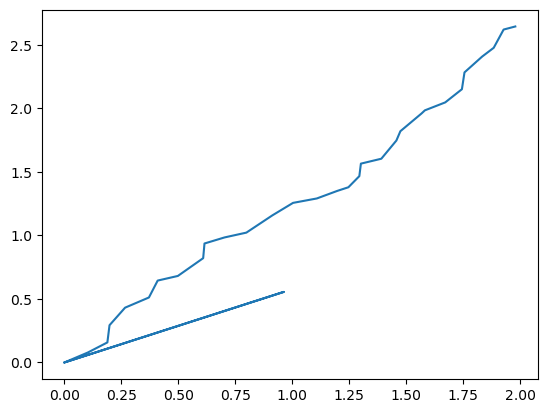

In [535]:
pos_x, pos_y = generate_walk(30, R = 10, theta = 30)
plt.plot(pos_x, pos_y, '-')
plt.show()

In [539]:
Px, Py = generate_walk_multi(length = 1000, R = 10, theta_lst=[0, 45, 30], n = 3)


In [540]:
print(Px[0])

[0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666667, 0.7777777777777779, 0.8888888888888891, 1.0000000000000002, 1.1111111111111114, 1.2222222222222225, 1.3333333333333337, 1.4444444444444449, 1.555555555555556, 1.6666666666666672, 1.7777777777777783, 1.8888888888888895, 2.0000000000000004, 2.1111111111111116, 2.2222222222222228, 2.333333333333334, 2.444444444444445, 2.5555555555555562, 2.6666666666666674, 2.7777777777777786, 2.8888888888888897, 3.000000000000001, 3.111111111111112, 3.222222222222223, 3.3333333333333344, 3.222222222222223, 3.111111111111112, 3.000000000000001, 2.8888888888888897, 2.7777777777777786, 2.6666666666666674, 2.5555555555555562, 2.444444444444445, 2.333333333333334, 2.2222222222222228, 2.1111111111111116, 2.0000000000000004, 1.8888888888888895, 1.7777777777777783, 1.6666666666666672, 1.555555555555556, 1.4444444444444449, 1.3333333333333337, 1.2222222222222225, 1.1111111111111114, 1.000000

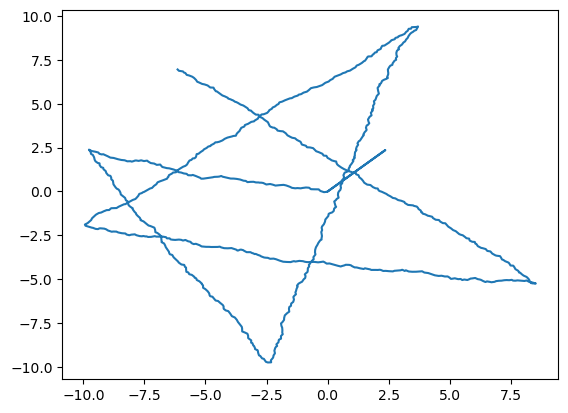

In [541]:
plt.plot(Px[1], Py[1], '-')
plt.show()

# GridCell (Behavior)

In [6]:
class GridCell(LIF) : 

    def __init__(
        self,
        R,
        threshold,
        tau,
        v_reset,
        v_rest,
        *args,
        init_v=None,
        init_s=None,
        **kwargs
    ):
        super().__init__(
                *args,
                R=R,
                tau=tau,
                threshold=threshold,
                v_reset=v_reset,
                v_rest=v_rest,
                init_v=init_v,
                init_s=init_s,
                **kwargs
            )
        
    def initialize(self, neurons) : 

        super().initialize(neurons)

        neurons.dir = torch.Tensor(neurons.size, 2)

        for i in range(neurons.NeuronDimension.height) :
            for j in range(neurons.NeuronDimension.width) :
                idx = i * neurons.NeuronDimension.height + j
                if(i % 2 == 0 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([0, 1])
                if(i % 2 == 0 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([0, -1])
                if(i % 2 == 1 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([1, 0])
                if(i % 2 == 1 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([-1, 0])

# GridDendriteComputation

In [185]:
class GridDendriteComputation(Behavior) :

    def initialize(self, neurons) :
        """
        convert the given random walk into speed vector and input current of grid cells.

        Args:
            I_ext (float) : External Input Current which is a constant feedforward throughout the simulation.
            I_vel (float) : Velocity current scaler.
            a (float) : envelope function coefficient.
            walk (tuple) : Tuple of (x, y) of positions in the random walk of length the size of simulation.
            orientation (float) : degree of orientation of the grid cell plane.
            offset_x (float) : offset of the origin of the grid cell plane X-axis.
            offset_y (float) : offset of the origin of the grid cell plane Y-axis.
        """

        self.I_ext = self.parameter("I_ext", 1)
        self.I_vel = self.parameter("I_vel", 0.175)
        self.a = self.parameter("a", 4)
        self.walk = self.parameter("walk", None, required = True)

        self.orientation = self.parameter("orientation", 0)
        self.offset_x = self.parameter("offset_x", 0)
        self.offset_y = self.parameter("offset_y", 0)

        neurons.I = neurons.vector(mode = self.I_ext)

    def forward(self, neurons) :
        itr = neurons.network.iteration

        prev = [0, 0]
        if(itr != 0) : prev = [self.walk[0][itr - 1], self.walk[1][itr - 1]]

        curr = [self.walk[0][itr], self.walk[1][itr]]

        speed_vector = torch.Tensor([curr[0] - prev[0], curr[1] - prev[1]])

        prev_vec = self.vector_resize(copy.deepcopy(speed_vector))
        speed_vector = self.rotate(speed_vector)
        speed_vector = self.vector_resize(speed_vector)
        
        neurons.I += (neurons.vector(f"normal({self.I_ext}, {0})") + self.I_vel * (speed_vector[0] * (neurons.dir[:, 0]) + speed_vector[1] * (neurons.dir[:, 1]))) * self.envelope(neurons)
        # if(itr < 20) : 
        #     print(prev_vec)
        #     print(speed_vector)
        #     print(speed_vector)
        #     print((speed_vector[0] * (neurons.dir[2080, 0]) + speed_vector[1] * (neurons.dir[2080, 1])))

    def envelope(self, neurons) :
        return torch.exp(-self.a * torch.sqrt(neurons.x**2 + neurons.y**2)/neurons.NeuronDimension.height)

    def relu(self, x) :
        return torch.maximum(x, torch.Tensor([0]))

    def rotate(self, speed_vector) : 
        phi = torch.tensor(self.orientation * math.pi / 180)
        s = torch.sin(phi)
        c = torch.cos(phi)
        rot = torch.stack([torch.stack([c, -s]),
                        torch.stack([s, c])])

        return speed_vector @ rot.t()

    def vector_resize(self, vel) : 
        sz = np.sqrt(vel[0]**2 + vel[1]**2)
        return vel/sz

# GridWeightInitializer()

TODO-LIST

- Lateral Inhitbtion?
- four types of Inhibition ? 
- Using Convolution ? 
- Due to fixed weights using simple Initializer. [**MAKE IT FASTER**]

In [8]:
class GridWeightInitializer(Behavior) :

    def initialize(self, synapse) :
        """
        Initialize the fixed synaptic weights in a grid cell plane based on a radius of connectivity.

        Args:
            R (int): Radius of connectivity and neighboring neurons in grid cell plane.
            w (float) : the constant synaptic weight in grid cell plane to each other.
            l (float) : Orientation prefence shift scaler.
        """

        self.R = self.parameter("R", required = True)
        self.l = self.parameter("l", required = True)
        self.a = self.parameter("a", 1)
        self.beta = self.parameter("beta", 0.2)
        self.gamma = self.parameter("gamma", 1.05)

        synapse.weights = synapse.matrix(mode = "zeros")

        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [DOWN]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        a = []
        for i in range(synapse.weights.shape[0]) : 
            a.append([])
            for j in range(synapse.weights.shape[1]) : 
                a[i].append(0)

        X = []
        Y = []
        Dir = []
        for i in synapse.src.x : 
            X.append(i.item())
                    
        for i in synapse.src.y : 
            Y.append(i.item())
        
        for i in synapse.src.dir : 
            Dir.append([])
            for j in range(2) : 
                Dir[-1].append(i[j].item())


        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [UP]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        for S in tqdm.tqdm(range(len(a))) :
            for D in range(len(a)) :
                x = X[S] - X[D] - self.l * Dir[S][0]
                y = Y[S] - Y[D] - self.l * Dir[S][1]

                sz_squared = x*x + y*y
                metric = 3/(13*13)

                a[S][D] = self.a * np.exp(-self.gamma * metric * sz_squared) - np.exp(-self.beta * metric * sz_squared)


        synapse.weights = torch.Tensor(a) * self.R

        
    def W0(self, x, y) :
        metric = 3/(13*13)
        
        return self.a * np.exp(-self.gamma * metric * sz_squared) - np.exp(-self.beta * metric * sz_squared)


    def dist(self, synapse, S, D) :
        """
        computes the euclidian distance between two 'S' and 'D' neurons in the grid cell plane.

        Args :
            synapse (SynapseGroup) : synapse group of the grid cell to itself.
            S (int) : index of the source neuron in grid cell neuron group.
            D (int) : index of the destination neuron in grid cell neuron group.
        """

        return (synapse.src.x[S] - synapse.dst.x[D] - synapse.src.dir[S][0])**2 + (synapse.src.y[S] - synapse.dst.y[D] - synapse.src.dir[S][1])**2

# Simulation

In [423]:
N = 25

In [636]:
Px, Py = generate_walk_multi(length = 1000, R = 10, theta_lst = [15, 105, 240, 15, 105, 240], n = 6)

In [647]:
net = Network(behavior = prioritize_behaviors([
    TimeResolution(dt = 1)
]))

Rs = [60, 100, 44, 60, 100, 47]
Bs = [2.0, 1.2, 1.5, 2.1, 1.4, 1.6]
Gs = [4.05, 2.05, 2.55, 4, 2.15, 2.6]

ngs = []
for i in range(6) : 
    ng = NeuronGroup(net = net, size = NeuronDimension(width = N, height = N), behavior = prioritize_behaviors([
        SimpleDendriteStructure(),
        SimpleDendriteComputation(),
        Fire(),
        KWTA(k = 25),
        # ActivityBaseHomeostasis(window_size=100, activity_rate=N*N//10, updating_rate=1.03, decay_rate=0.88),
        NeuronAxon()
    ]) | ({
        241 : GridDendriteComputation(
            walk = (Px[0], Py[0]),
            a = 2, 
            orientation = 0,
            offset_x = 0, 
            offset_y = 0,
            I_ext = 50,
            I_vel = 25
        ),
        260 : GridCell(
            R = 10,
            tau = 5,
            threshold = -63,
            v_rest = -65,
            v_reset = -67,
            init_v =  65
        ),
        
        600 : Recorder(["I", "v"]),
        601 : EventRecorder(['spikes'])
    }))

    sg = SynapseGroup(net = net, src = ng, dst = ng, tag = "Proximal,exi", behavior = prioritize_behaviors([
        SynapseInit(),
        SimpleDendriticInput(),
    ]) | {
        280 : GridWeightInitializer(R = Rs[i], a = 1, beta = Bs[i], gamma = Gs[i], l = 2)
    })

    ngs.append(ng)

In [648]:
net.initialize()
net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(3750)|6 groups, Synapses: tensor(2343750)|6 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](625){0:NeuronDimension(depth=1,height=25,width=25,input_patterns=None,)220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=None,apical_provocativeness=None,distal_provocativeness=None,)241:GridDendriteComputation(walk=([0, 0.10732509180989648, 0.21465018361979296, 0.32197527542968946, 0.4293003672395859, 0.5366254590494824, 0.6439505508593789, 0.7512756426692754, 0.8586007344791718, 0.9659258262890683, 1.073250918098965, 1.1805760099088614, 1.2879011017187578, 1.3952261935286543, 1.5025512853385508, 1.6098763771484472, 1.7172014689583437, 1.8245265607682402, 1.9318516525781366, 2.0391767443880333, 2.14650183619793, 2.2538269280078262, 2.3611520198177227, 2.468477111627619, 2.5758022034375156,

100%|██████████| 625/625 [00:01<00:00, 601.50it/s]


1000xBatch: 1/1 (100%) 14708.508ms


14708.508491516113

In [568]:
def iter_spike_multi(pos_x, pos_y, ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs", label = "grid", offset_x = 0, offset_y = 0, base_offset_x = 0, base_offset_y = 0) :
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]
    ng_idx_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 4][:,1]
    ng_idx_prev_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 8][:,1]

    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    plt.plot((pos_X[prev:itr*step] + base_offset_x) * -1, (pos_Y[prev:itr*step] + base_offset_y) * -1, color = 'gray')
    
    plt.plot((ng.x[ng_idx_prev_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.2)
    plt.plot((ng.x[ng_idx_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.5)
    plt.plot((ng.x[ng_idx] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, label = label)
    plt.legend(loc = 'upper right')

    plt.plot((pos_x[itr*step] + base_offset_x) * -1, (pos_y[itr*step] + base_offset_y)* -1, '^', color = 'red', markersize = 10)

    plt.title(f"iteration = {itr * step}", y = -0.2)
    plt.suptitle("Grid Module Spikes")

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

In [569]:
def iter_spike_multi_real(pos_x, pos_y, ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs", label = "grid", offset_x = 0, offset_y = 0, base_offset_x = 0, base_offset_y = 0) :
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]
    ng_idx_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 4][:,1]
    ng_idx_prev_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 8][:,1]

    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    plt.plot((pos_X[prev:itr*step] + base_offset_x) * -1, (pos_Y[prev:itr*step] + base_offset_y) * -1, color = 'gray')
    
    # plt.plot((ng.x[ng_idx_prev_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.2)
    # plt.plot((ng.x[ng_idx_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.35)
    plt.plot((ng.x[ng_idx] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, label = label, alpha = 1)
    plt.legend(loc = 'upper right')

    plt.plot((pos_x[itr*step] + base_offset_x) * -1, (pos_y[itr*step] + base_offset_y)* -1, '^', color = 'red', markersize = 10)

    plt.title(f"iteration = {itr * step}", y = -0.2)
    plt.suptitle("Grid Module Spikes")

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

tensor([ 0., -1.])


<Axes: >

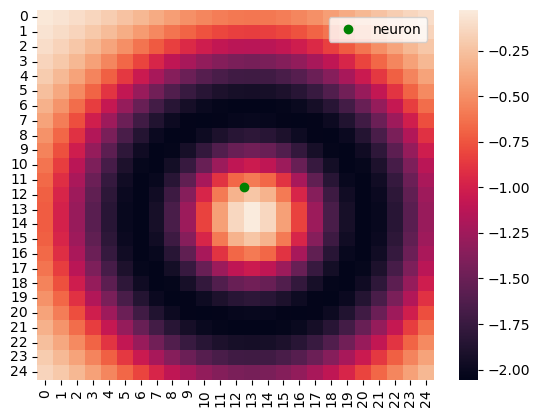

In [570]:
W_base = sg.weights[N//2*N + N//2 + 1].view((ng.width, ng.height))
print(ng.dir[N//2*N + N//2 + 1])
plt.plot((N//2*N + N//2 + 1)%N, (N//2*N + N//2 + 1)//N,'o', color = 'green', label = "neuron")
plt.legend()
sns.heatmap(W_base)

In [2]:
ng_I = ngs[1]["v", 0][10, :].view((ng.width, ng.height))
ng_I.shape

torch.max(ng_I)

sns.heatmap(ng_I)

NameError: name 'ngs' is not defined

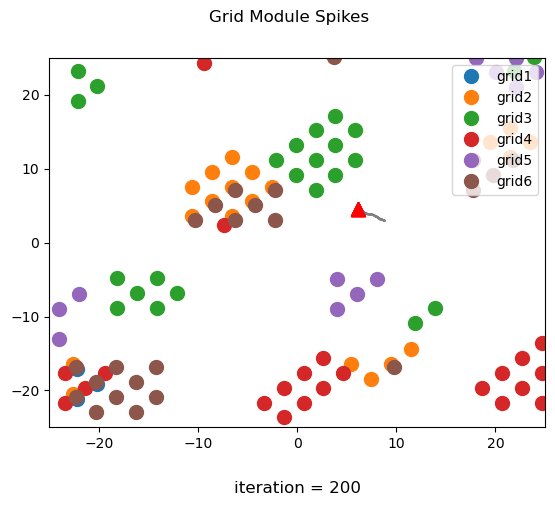

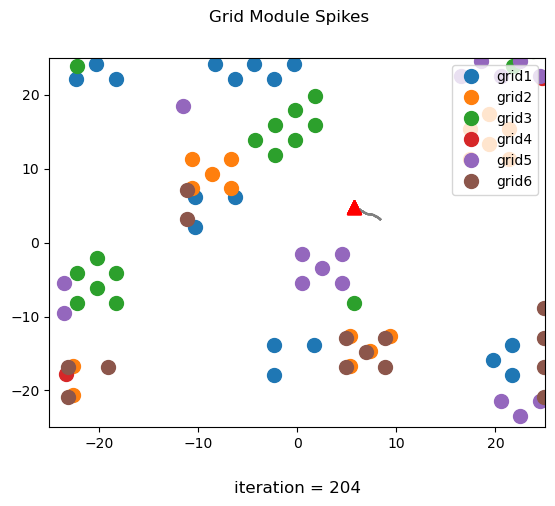

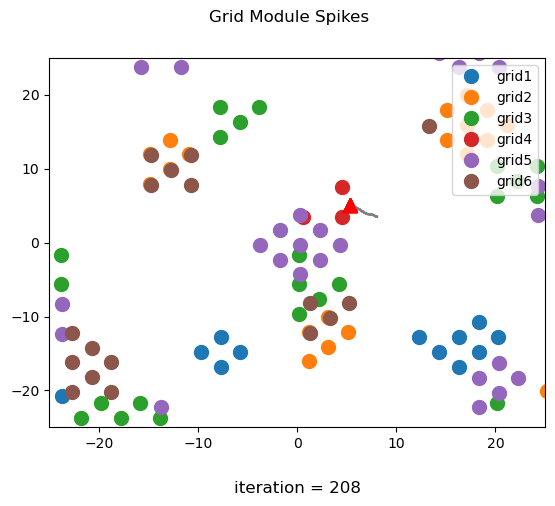

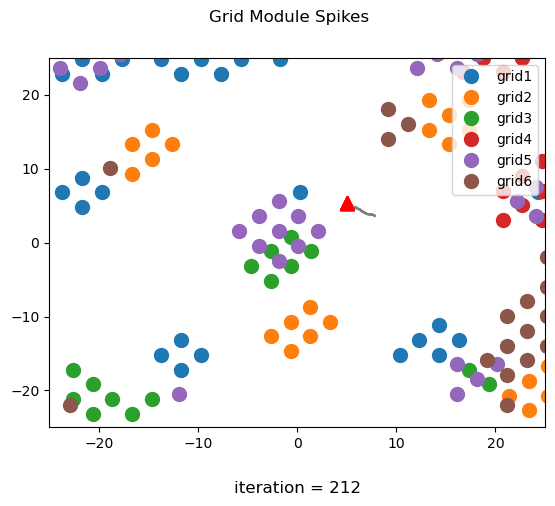

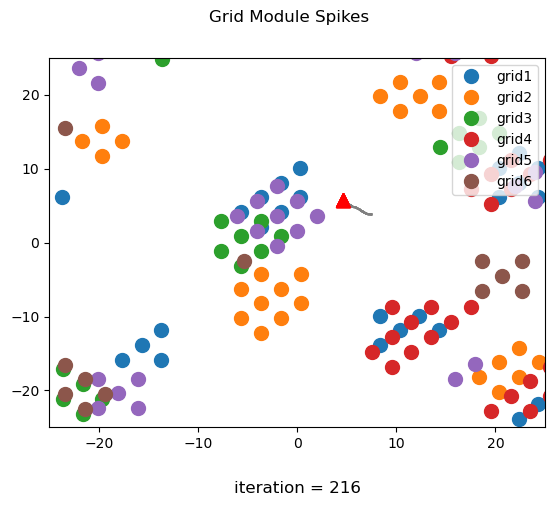

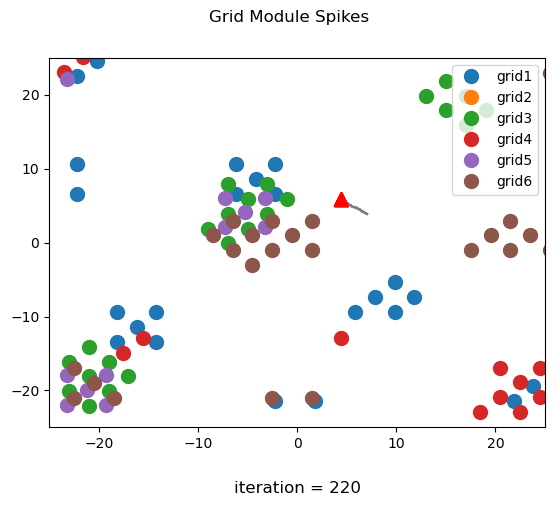

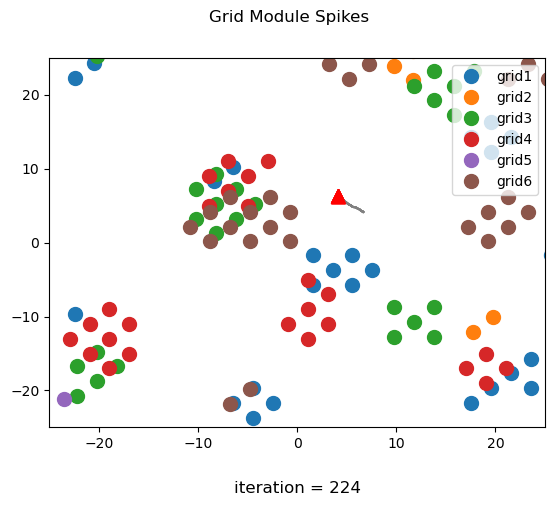

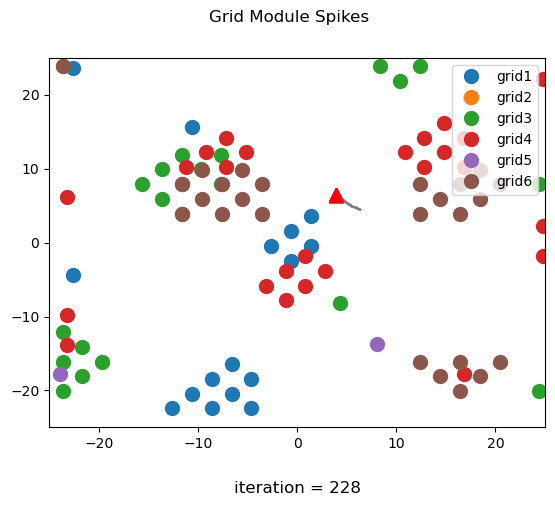

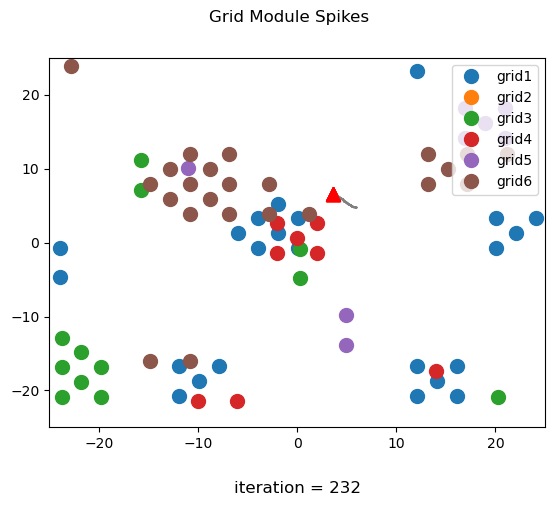

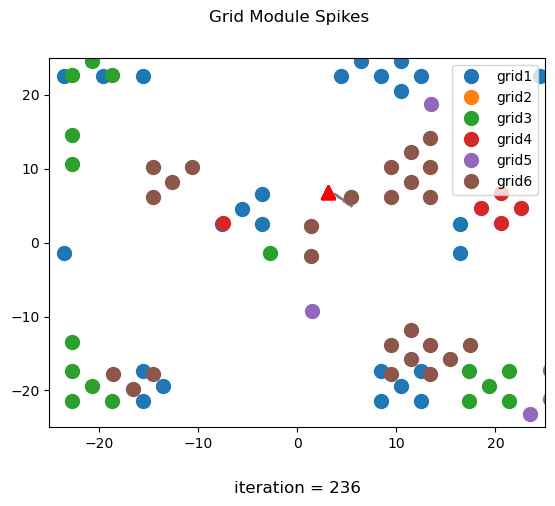

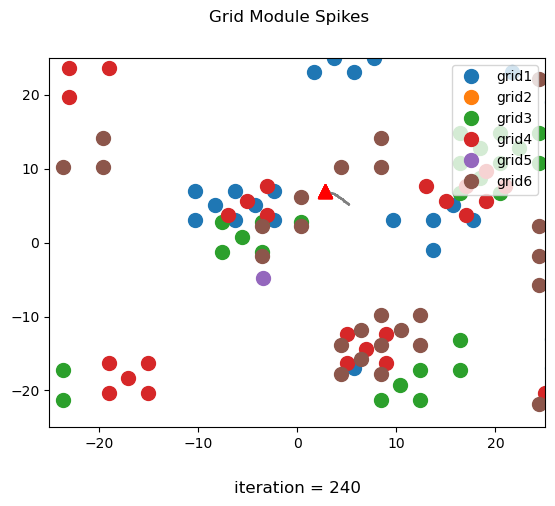

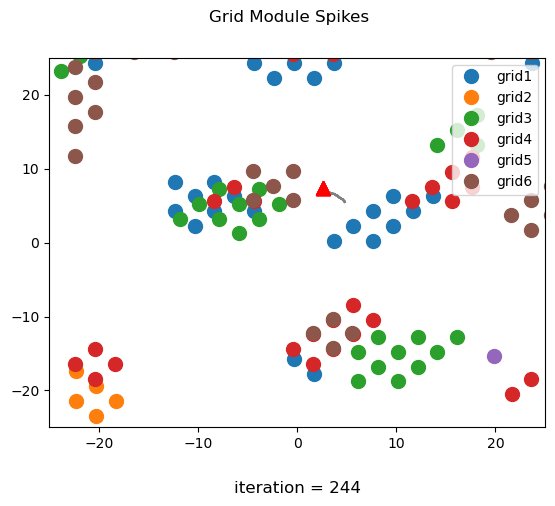

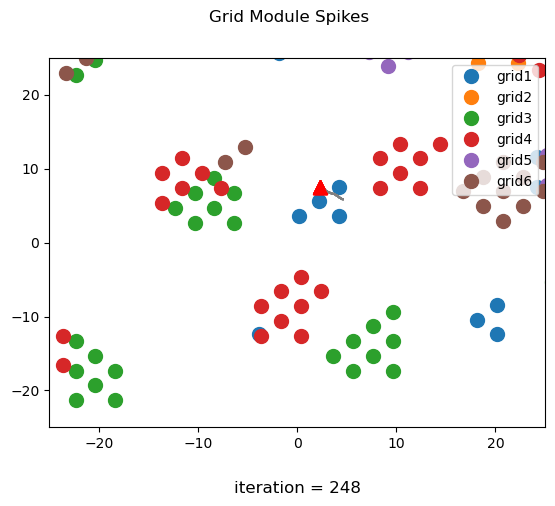

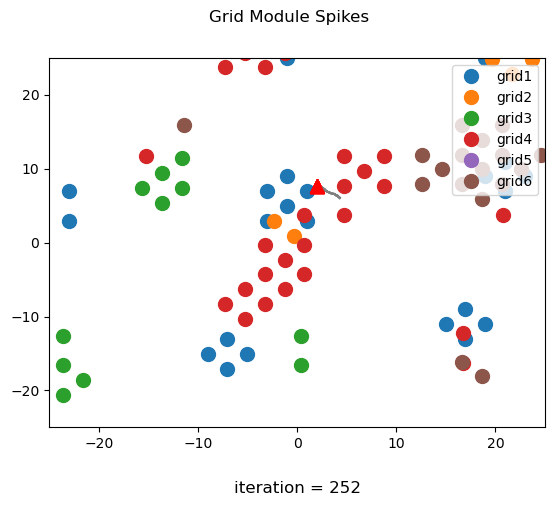

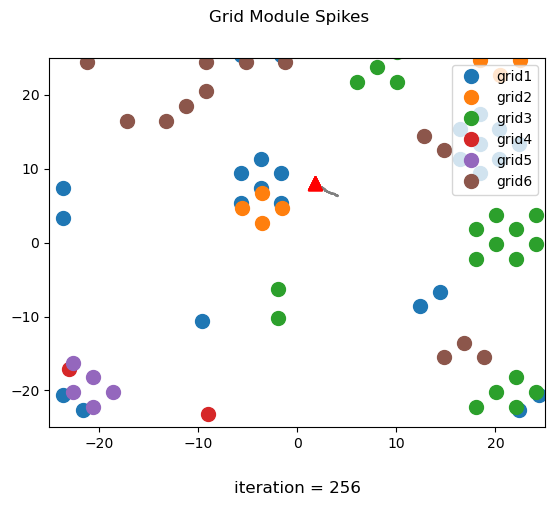

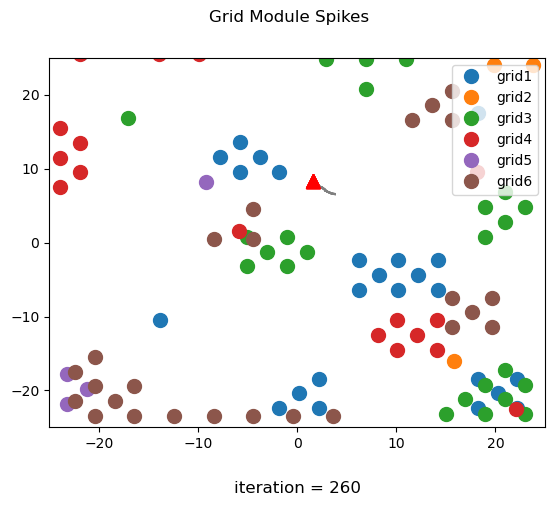

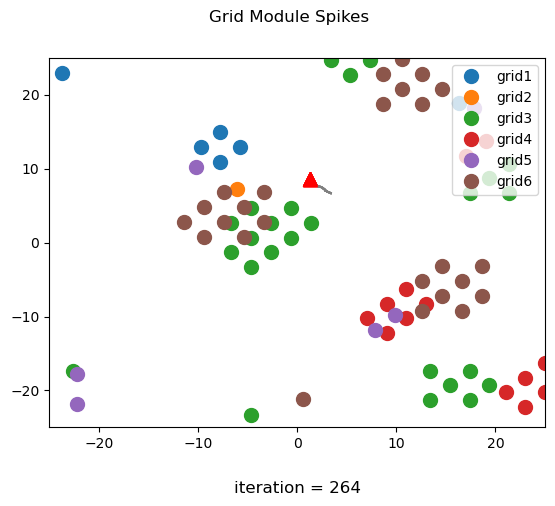

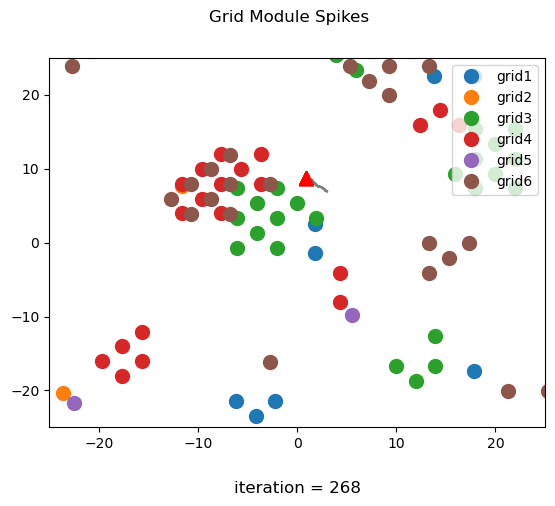

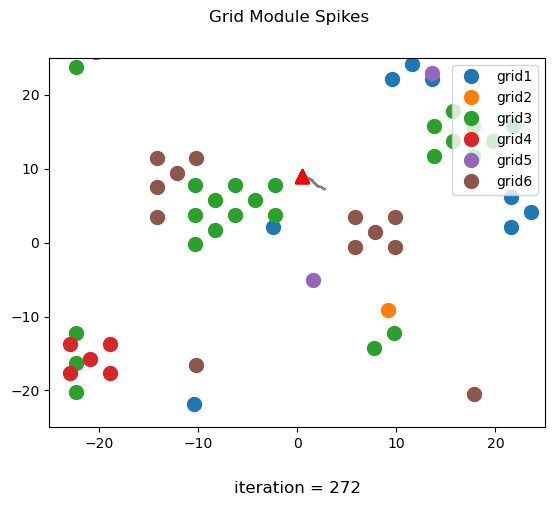

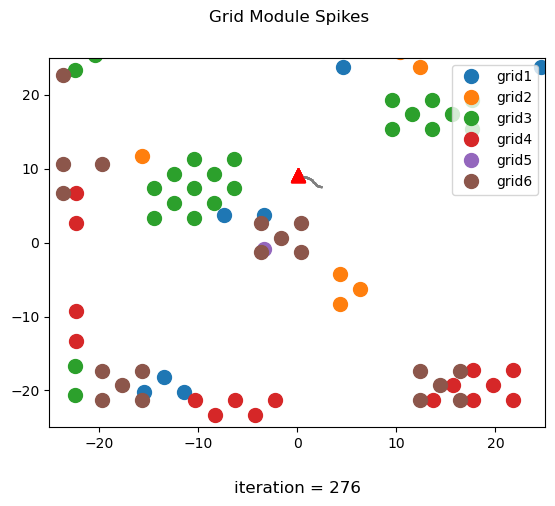

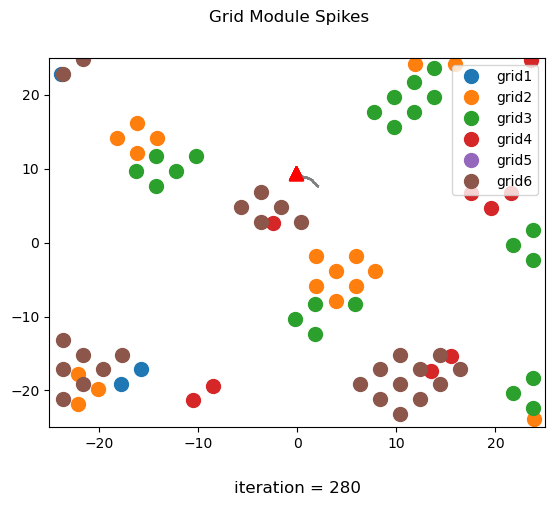

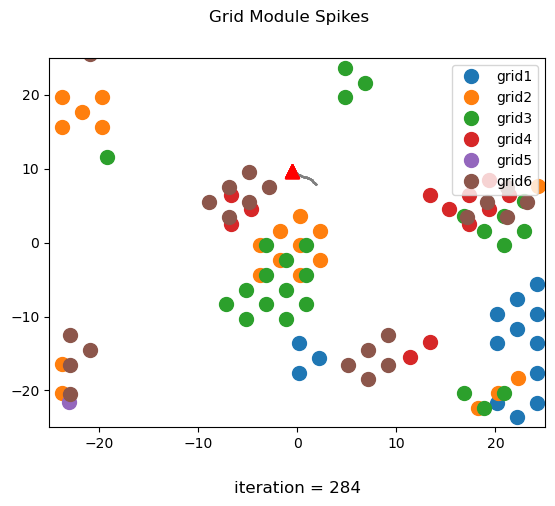

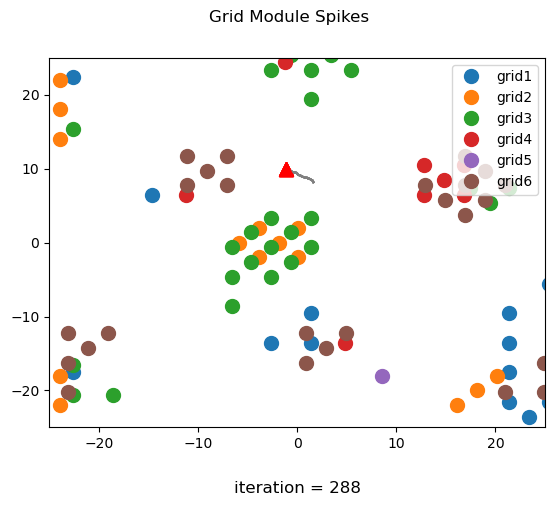

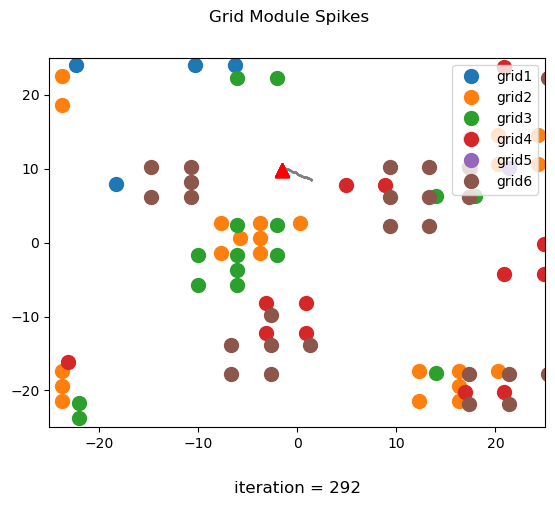

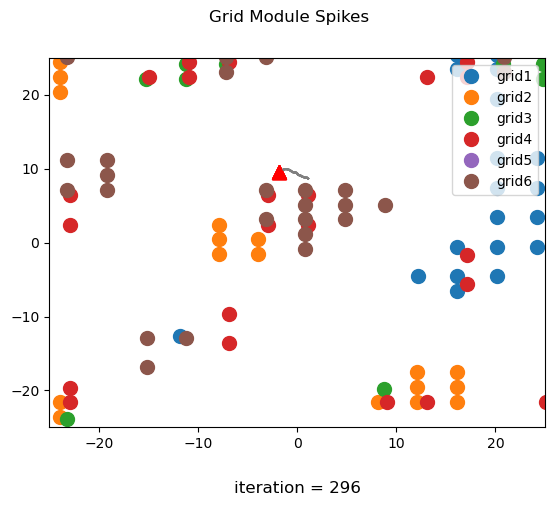

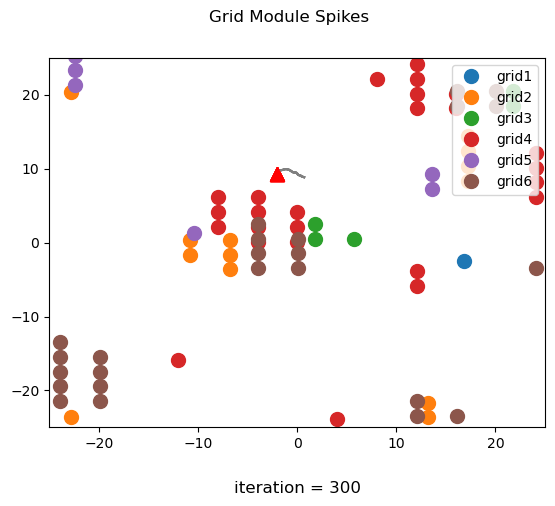

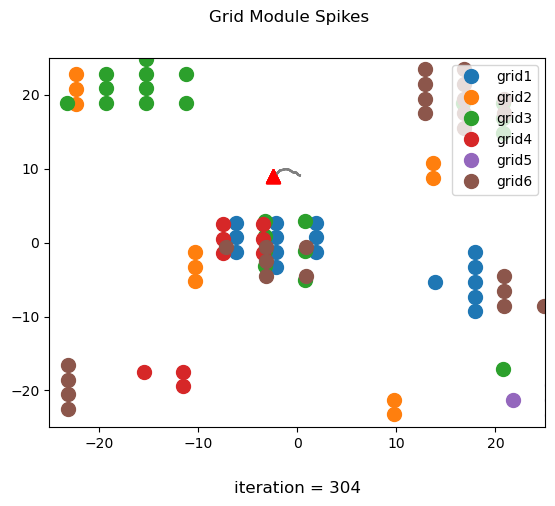

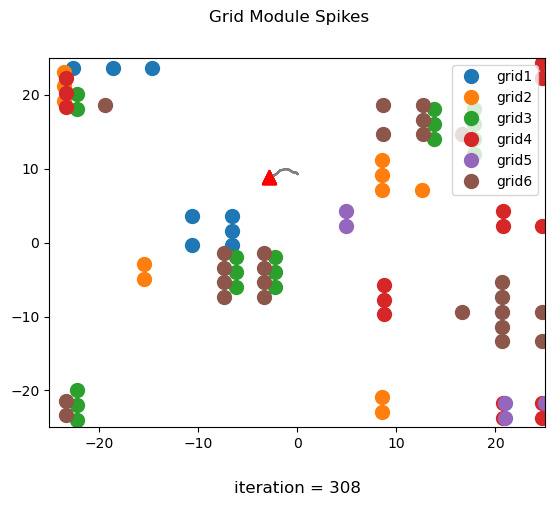

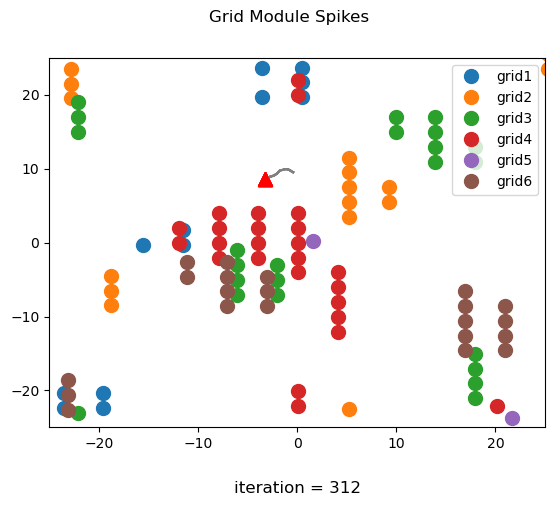

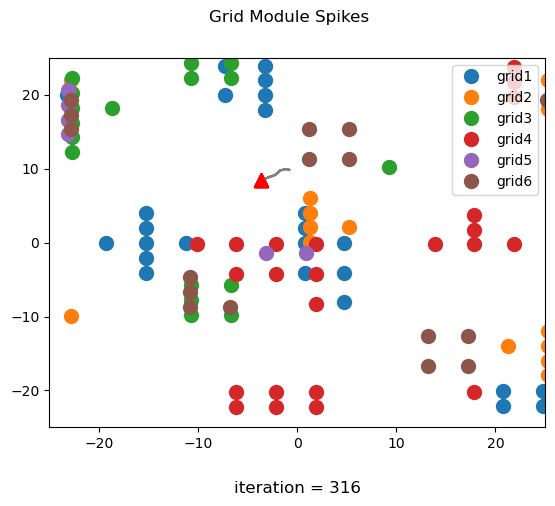

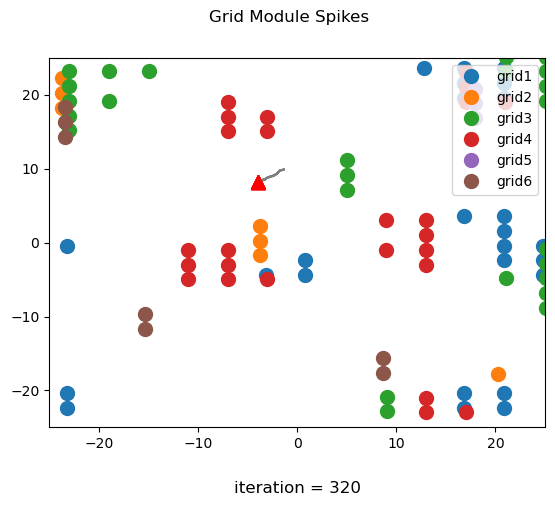

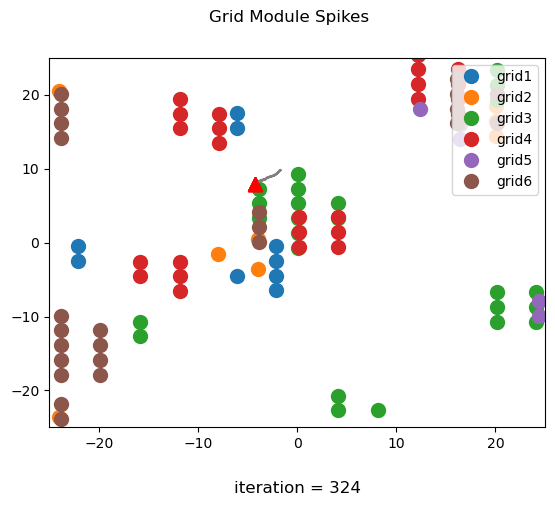

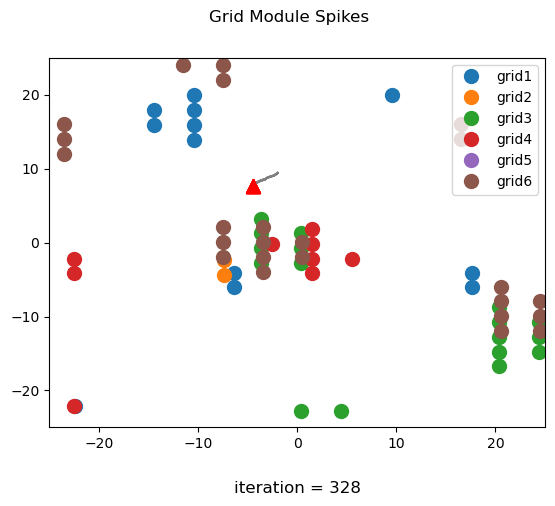

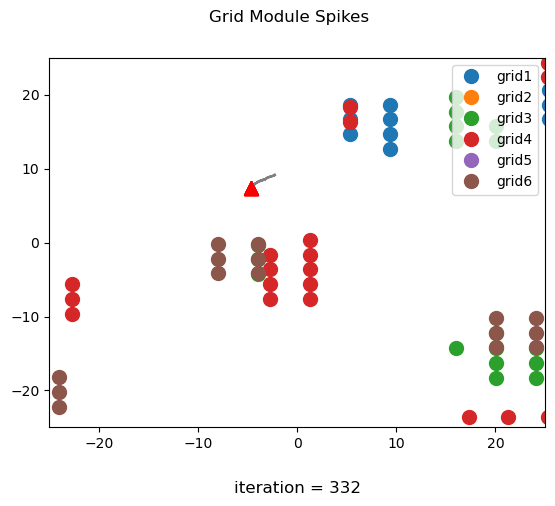

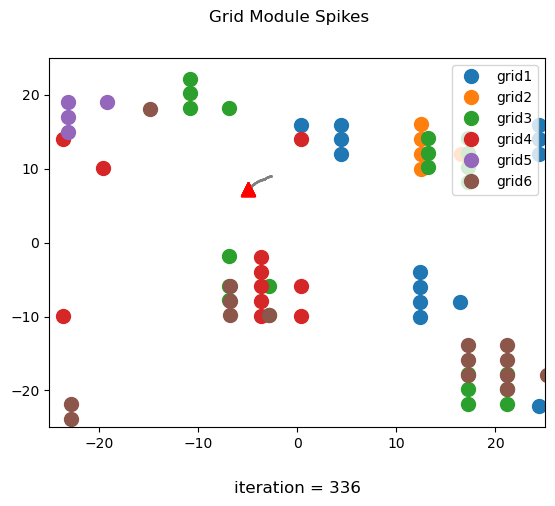

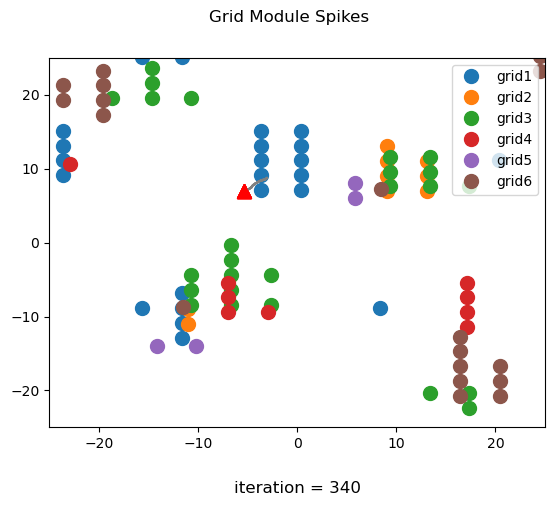

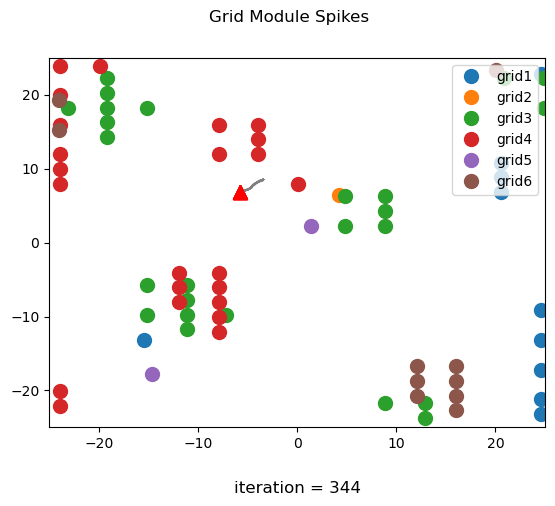

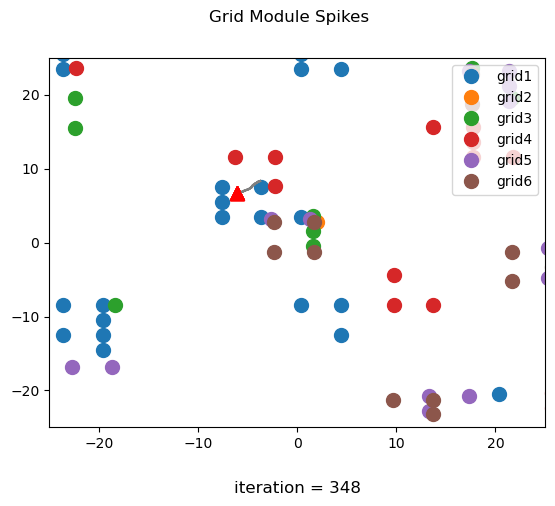

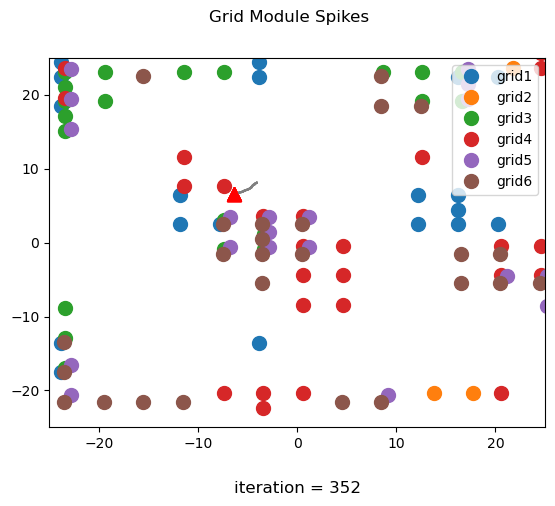

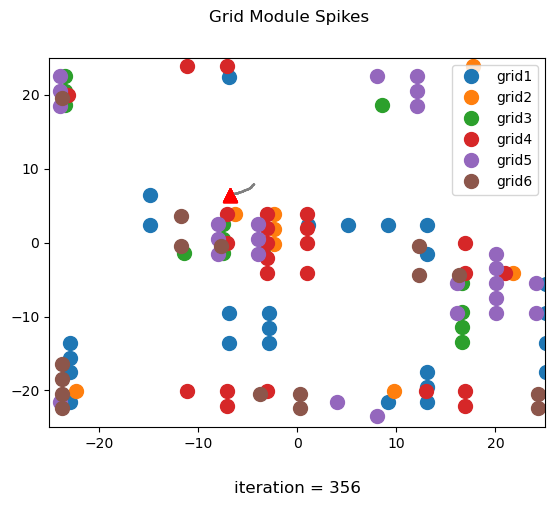

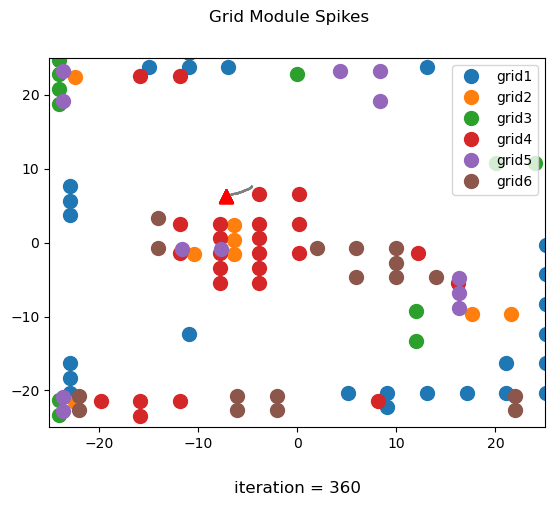

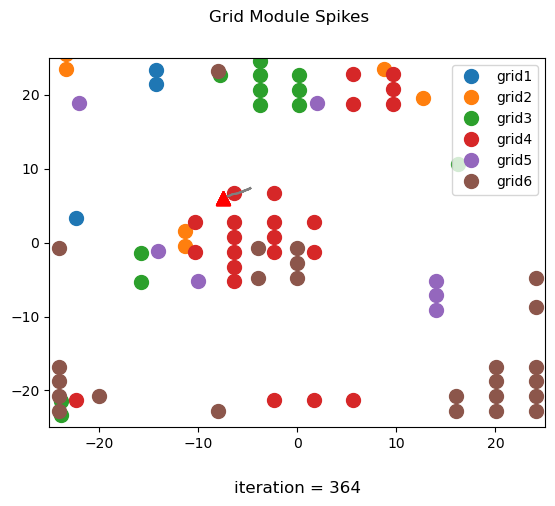

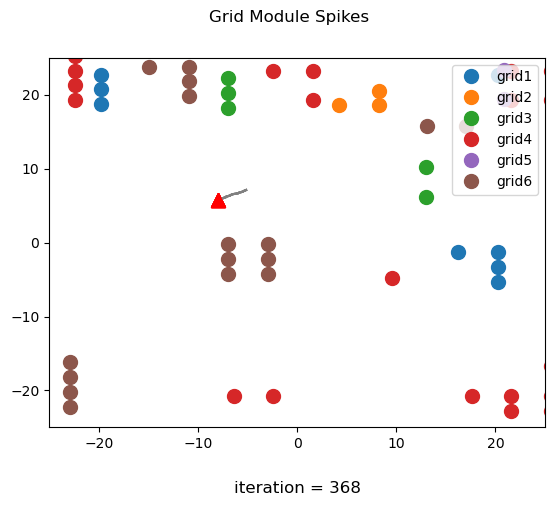

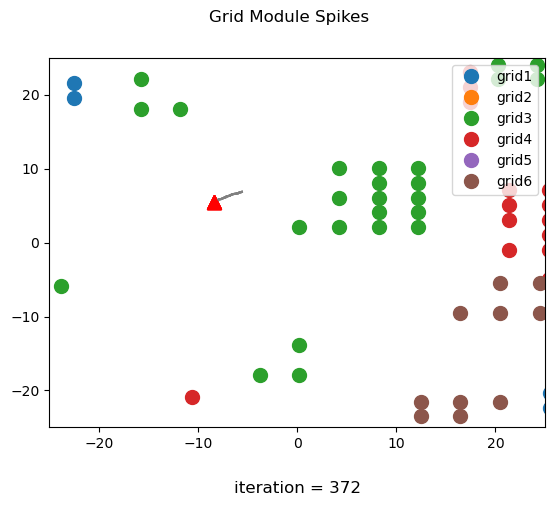

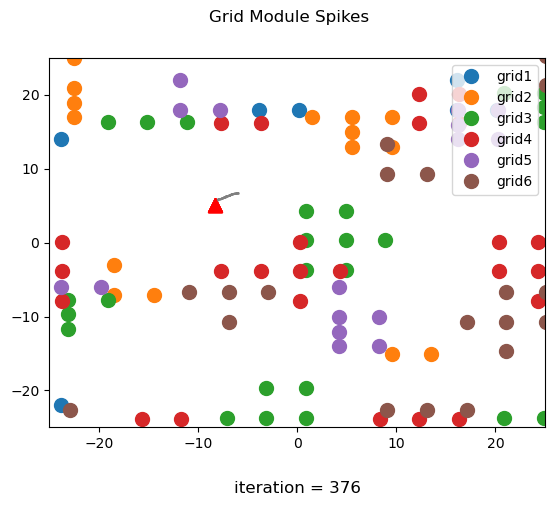

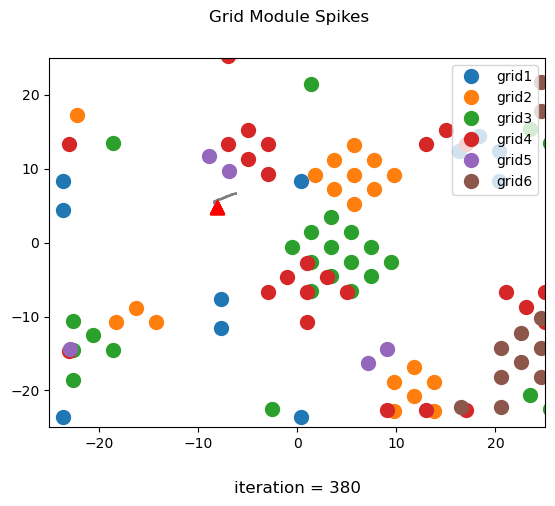

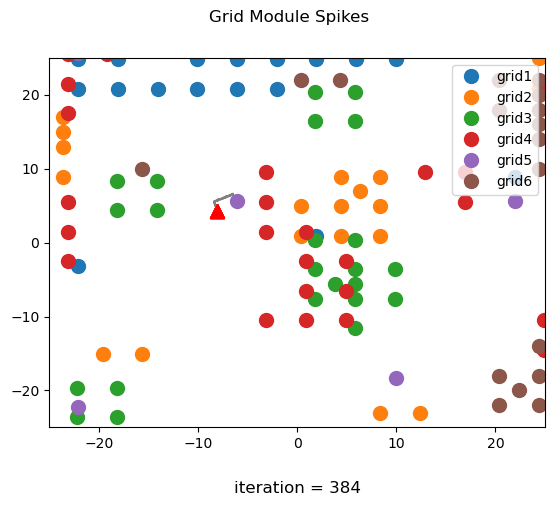

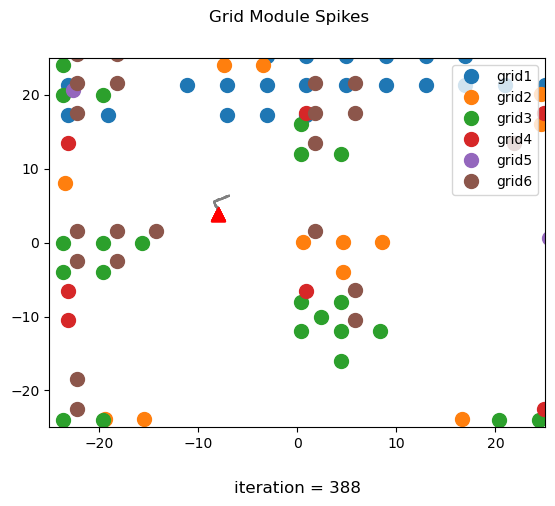

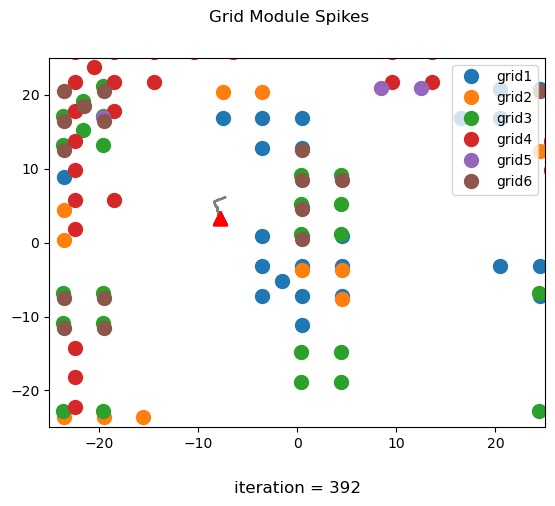

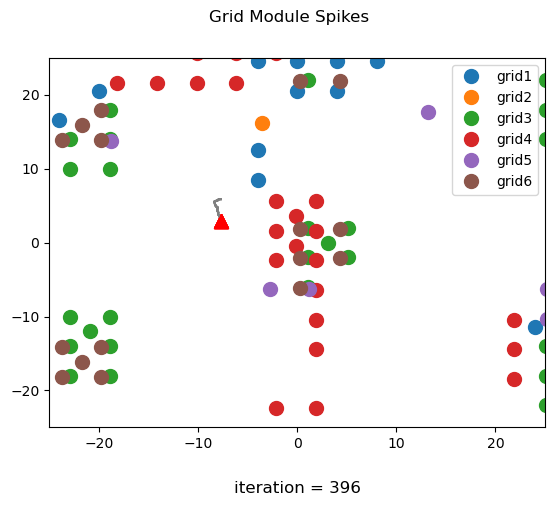

In [651]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])


for i in range(50, 100) :
    cnt = 0
    for ng in ngs : 
        iter_spike_multi_real(
            Px[0],
            Py[0],
            ngs[cnt],
            itr = i, 
            step = 4, 
            color = colors[cnt], 
            save = True, 
            lib = "sh", 
            label = "grid" + str(cnt + 1), 
            offset_x = 0 + random.random(), 
            offset_y = 0 + random.random(),
            base_offset_x = 0,
            base_offset_y = 0
            )
        cnt += 1
        # break
        
    plt.show()